In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/Colab Notebooks/HAN

/content/drive/My Drive/Colab Notebooks/HAN


In [3]:
ls

Character_CNN_LSTM.ipynb  MyNormalizer.py  Untitled7.ipynb
IIITH_Codemixed.txt       __pycache__/


In [0]:

import numpy as np
import h5py
import pickle
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing import sequence
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers import Conv1D
import tensorflow as tf

from keras.utils import np_utils
from MyNormalizer import token

################# GLOBAL VARIABLES #####################

inputdatasetfilename = 'IIITH_Codemixed.txt'


#Data I/O formatting
SEPERATOR = '\t'
DATA_COLUMN = 1
LABEL_COLUMN = 3
LABELS = ['0','1','2'] # 0 -> Negative, 1-> Neutral, 2-> Positive
mapping_char2num = {}
mapping_num2char = {}
MAXLEN = 200

#LSTM Model Parameters
#Embedding
MAX_FEATURES = 0
embedding_size = 128
# Convolution
filter_length = 3
nb_filter = 128
pool_length = 3
# LSTM
lstm_output_size = 128
# Training
batch_size = 128
number_of_epochs = 80
numclasses = 3
test_size = 0.2
########################################################

def parse(filename,seperator,labelcol,labels,datacol):
	"""
	Purpose -> Data I/O
	Input   -> Data file containing sentences and labels along with the global variables
	Output  -> Sentences cleaned up in list of lists format along with the labels as a numpy array
	"""
	f=open(filename,'r',encoding='utf-8')
	lines = f.read().lower()
	lines = lines.lower().split('\n')[:-1]

	X_train = []
	Y_train = []
	
	for line in lines:
		line = line.split(seperator)
		tokenized_lines = token(line[datacol])
		
		char_list = []
		for words in tokenized_lines:
			for char in words:
				char_list.append(char)
			char_list.append(' ')
		#print(char_list) - Debugs the character list created
		X_train.append(char_list)
		
		#Appends labels
		if line[labelcol] == labels[0]:
			Y_train.append(0)
		if line[labelcol] == labels[1]:
			Y_train.append(1)
		if line[labelcol] == labels[2]:
			Y_train.append(2)
	
	#Converts Y_train to a numpy array	
	Y_train = np.asarray(Y_train)
	assert(len(X_train) == Y_train.shape[0])

	return [X_train,Y_train]

def convert_char2num(mapping_n2c,mapping_c2n,trainwords,maxlen):
	"""
	Purpose -> Convert characters to integers, a unique value for every character
	Input   -> Training data (In list of lists format) along with global variables
	Output  -> Converted training data along with global variables
	"""
	allchars = []
	errors = 0

	for line in trainwords:
		try:
			allchars = set(allchars+line)
			allchars = list(allchars)
		except:
			errors += 1

	charno = 0
	for char in allchars:
		mapping_char2num[char] = charno
		mapping_num2char[charno] = char
		charno += 1

	assert(len(allchars)==charno) 

	#Converts the data from characters to numbers using dictionaries 
	X_train = []
	for line in trainwords:
		char_list=[]
		for letter in line:
			char_list.append(mapping_char2num[letter])
		X_train.append(char_list)
	print(mapping_char2num)
	print(mapping_num2char)
	X_train = sequence.pad_sequences(X_train[:], maxlen=maxlen)
	return [X_train,mapping_num2char,mapping_char2num,charno]



def get_activations(model, layer, X_batch):
	"""
	Purpose -> Obtains outputs from any layer in Keras
	Input   -> Trained model, layer from which output needs to be extracted & files to be given as input
	Output  -> Features from that layer 
	"""
	#Referred from:- TODO: Enter the forum link from where I got this
	get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
	activations = get_activations([X_batch,0])
	return activations

def evaluate_model(X_test,y_test,model,batch_size,numclasses):
	"""
	Purpose -> Evaluate any model on the testing data
	Input   -> Testing data and labels, trained model and global variables
	Output  -> Nil
	"""
	#Convert y_test to one-hot encoding
	y_test = np_utils.to_categorical(y_test, numclasses)
	#Evaluate the accuracies
	score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
	print('Test score:', score)
	print('Test accuracy:', acc)




In [14]:
    out = parse(inputdatasetfilename,SEPERATOR,LABEL_COLUMN,LABELS,DATA_COLUMN)
    global X_train
    global y_train
    global X_test
    global y_test
    X_train = out[0]
    y_train = out[1]
    print(y_train)
    print('Creating character dictionaries and format conversion in progess...')
    out = convert_char2num(mapping_num2char,mapping_char2num,X_train,MAXLEN)
    mapping_num2char = out[1]
    mapping_char2num = out[2]
    MAX_FEATURES = out[3]
    X_train = np.asarray(out[0])
    y_train = np.asarray(y_train).flatten()
    print('Splitting data into train and test...')
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    y_train=tf.keras.utils.to_categorical(y_train)
    y_test=tf.keras.utils.to_categorical(y_test)


[2 2 1 ... 2 2 2]
Creating character dictionaries and format conversion in progess...
{'x': 0, 'i': 1, 'y': 2, 'v': 3, 't': 4, ' ': 5, 's': 6, 'm': 7, 'f': 8, 'p': 9, 'n': 10, 'd': 11, 'r': 12, 'z': 13, 'q': 14, 'g': 15, 'c': 16, 'u': 17, 'h': 18, 'j': 19, 'b': 20, 'o': 21, 'e': 22, 'w': 23, 'k': 24, 'l': 25, 'a': 26}
{0: 'x', 1: 'i', 2: 'y', 3: 'v', 4: 't', 5: ' ', 6: 's', 7: 'm', 8: 'f', 9: 'p', 10: 'n', 11: 'd', 12: 'r', 13: 'z', 14: 'q', 15: 'g', 16: 'c', 17: 'u', 18: 'h', 19: 'j', 20: 'b', 21: 'o', 22: 'e', 23: 'w', 24: 'k', 25: 'l', 26: 'a'}
Splitting data into train and test...


In [15]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 2.6MB/s 


In [16]:
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from keras.optimizers import Adamax

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',
                         name='learning_rate')
dim_no_epoch = Integer(low=20, high=80, name='no_epoch')
dim_embedding_size = Integer(low=16, high=256, name='embedding_size')
dim_lstm_output_size = Integer(low=16, high=256, name='lstm_output_size')
dim_pool_length =Integer(low=2,high=5,name='pool_length')
dim_batch_size = Integer(low=1, high=128, name='batch_size')
dim_adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")
dim_no_filter = Integer(low=16,high=256,name='no_filter')

dimensions = [dim_learning_rate,
              dim_batch_size,
              dim_adam_decay,
              dim_embedding_size,
              dim_lstm_output_size,
              dim_no_epoch,
              dim_no_filter,
             ]
default_parameters = [1e-3,32,1e-3, 128,128,50,128]

In [0]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate,batch_size,adam_decay,embedding_size,lstm_output_size,no_epoch,no_filter):
    model = Sequential()
    model.add(Embedding(MAX_FEATURES, embedding_size, input_length=MAXLEN))
    model.add(Convolution1D(nb_filter=no_filter,filter_length=filter_length,border_mode='valid',activation='relu',subsample_length=1))
    model.add(MaxPooling1D(pool_length=pool_length))
    model.add(LSTM(lstm_output_size, dropout_W=0.2, dropout_U=0.2, return_sequences=True))
    model.add(LSTM(lstm_output_size, dropout_W=0.2, dropout_U=0.2, return_sequences=False))
    model.add(Dense(numclasses))
    model.add(Activation('softmax'))
    
    admax=Adamax(lr=learning_rate,decay=adam_decay)
    
    model.compile(loss='categorical_crossentropy',optimizer=admax,metrics=['accuracy'])
    
    X_train1,X_valid,y_train1,y_valid=train_test_split(X_train,y_train,test_size=0.2,random_state=42)
    bb=model.fit(X_train1, y_train1, batch_size=batch_size, shuffle=True, nb_epoch=no_epoch,validation_data=(X_valid, y_valid))
    
    accuracy=bb.history['val_acc'][-1]
    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    K.clear_session()
    tf.reset_default_graph()
    
    return -accuracy

In [19]:
K.clear_session()
tf.reset_default_graph()

In [20]:
gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=12,
                            noise= 0.01,
                            n_jobs=-1,
                            kappa = 5,
                            x0=default_parameters)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.





Train on 2482 samples, validate on 621 samples
Epoch 1/50





2482/2482 [==============================] - 34s 14ms/step - loss: 0.9880 - acc: 0.5036 - val_loss: 0.9966 - val_acc: 0.4815
Epoch 2/50
2482/2482 [==============================] - 25s 10ms/step - loss: 0.9677 - acc: 0.5093 - val_loss: 0.9814 - val_acc: 0.4815
Epoch 3/50
2482/2482 [==============================] - 25s 10ms/step - loss: 0.9541 - acc: 0.5181 - val_loss: 0.9709 - val_acc: 0.4799
Epoch 4/50
2482/2482 [==============================] - 25s 10ms/step - loss: 0.9387 - acc: 0.5318 - val_loss: 0.9620 - val_acc: 0.4928
Epoch 5/50
2482/2482 [==============================] - 25s 10ms/step - loss: 0.9148 - acc: 0.5604 - val_loss: 0.9314 - val_acc: 0.5072
Epoch 6/50
2482/2482 [==============================] - 25s 10ms/step - loss: 0.8897 - acc: 0.5761 - val_loss: 0.9077 - val_acc: 0.5668
Epoch 7/50
2482/2482 [==============================] - 25s 10ms/step - loss: 0.8700 - acc: 0.5882 - val_loss: 0.8955 - val_acc: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=17, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(41, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(41, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/70
2482/2482 [==============================] - 100s 40ms/step - loss: 0.9730 - acc: 0.5157 - val_loss: 0.9733 - val_acc: 0.4879
Epoch 2/70
2482/2482 [==============================] - 99s 40ms/step - loss: 0.9577 - acc: 0.5246 - val_loss: 0.9645 - val_acc: 0.4928
Epoch 3/70
2482/2482 [==============================] - 99s 40ms/step - loss: 0.9385 - acc: 0.5387 - val_loss: 0.9499 - val_acc: 0.4911
Epoch 4/70
2482/2482 [==============================] - 99s 40ms/step - loss: 0.9231 - acc: 0.5475 - val_loss: 0.9395 - val_acc: 0.5072
Epoch 5/70
2482/2482 [==============================] - 98s 40ms/step - loss: 0.9106 - acc: 0.5504 - val_loss: 0.9486 - val_acc: 0.5185
Epoch 6/70
2482/2482 [==============================] - 98s 40ms/step - loss: 0.8983 - acc: 0.5669 - val_loss: 0.9210 - val_acc: 0.5217
Epoch 7/70
2482/2482 [==============================] - 99s 40ms/step - loss: 0.8876 - acc: 0.5818 - val_loss: 0.9216 - val_acc: 0.5507


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=77, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(184, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(184, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/31
2482/2482 [==============================] - 16s 6ms/step - loss: 0.9914 - acc: 0.5077 - val_loss: 0.9938 - val_acc: 0.4815
Epoch 2/31
2482/2482 [==============================] - 13s 5ms/step - loss: 0.9728 - acc: 0.5089 - val_loss: 0.9886 - val_acc: 0.4815
Epoch 3/31
2482/2482 [==============================] - 13s 5ms/step - loss: 0.9605 - acc: 0.5097 - val_loss: 0.9900 - val_acc: 0.4815
Epoch 4/31
2482/2482 [==============================] - 13s 5ms/step - loss: 0.9569 - acc: 0.5222 - val_loss: 0.9826 - val_acc: 0.4895
Epoch 5/31
2482/2482 [==============================] - 13s 5ms/step - loss: 0.9528 - acc: 0.5318 - val_loss: 0.9752 - val_acc: 0.4847
Epoch 6/31
2482/2482 [==============================] - 13s 5ms/step - loss: 0.9425 - acc: 0.5383 - val_loss: 0.9707 - val_acc: 0.4928
Epoch 7/31
2482/2482 [==============================] - 13s 5ms/step - loss: 0.9390 - acc: 0.5326 - val_loss: 0.9696 - val_acc: 0.4928
Epoch 8/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=146, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(249, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(249, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/56
2482/2482 [==============================] - 17s 7ms/step - loss: 0.9859 - acc: 0.5060 - val_loss: 0.9900 - val_acc: 0.4815
Epoch 2/56
2482/2482 [==============================] - 15s 6ms/step - loss: 0.9558 - acc: 0.5165 - val_loss: 0.9866 - val_acc: 0.4831
Epoch 3/56
2482/2482 [==============================] - 15s 6ms/step - loss: 0.9442 - acc: 0.5290 - val_loss: 0.9549 - val_acc: 0.4944
Epoch 4/56
2482/2482 [==============================] - 15s 6ms/step - loss: 0.9160 - acc: 0.5508 - val_loss: 0.9218 - val_acc: 0.5314
Epoch 5/56
2482/2482 [==============================] - 15s 6ms/step - loss: 0.8879 - acc: 0.5745 - val_loss: 0.9123 - val_acc: 0.5427
Epoch 6/56
2482/2482 [==============================] - 15s 6ms/step - loss: 0.8735 - acc: 0.5830 - val_loss: 0.8999 - val_acc: 0.5604
Epoch 7/56
2482/2482 [==============================] - 15s 6ms/step - loss: 0.8612 - acc: 0.5886 - val_loss: 0.8916 - val_acc: 0.5684
Epoch 8/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=229, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(130, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(130, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/34
2482/2482 [==============================] - 44s 18ms/step - loss: 0.9743 - acc: 0.5000 - val_loss: 0.9592 - val_acc: 0.5089
Epoch 2/34
2482/2482 [==============================] - 41s 17ms/step - loss: 0.9163 - acc: 0.5560 - val_loss: 0.9276 - val_acc: 0.5330
Epoch 3/34
2482/2482 [==============================] - 41s 17ms/step - loss: 0.8791 - acc: 0.5850 - val_loss: 0.8879 - val_acc: 0.5797
Epoch 4/34
2482/2482 [==============================] - 41s 17ms/step - loss: 0.8351 - acc: 0.6213 - val_loss: 0.8435 - val_acc: 0.6023
Epoch 5/34
2482/2482 [==============================] - 41s 17ms/step - loss: 0.8010 - acc: 0.6394 - val_loss: 0.8280 - val_acc: 0.6151
Epoch 6/34
2482/2482 [==============================] - 41s 16ms/step - loss: 0.7655 - acc: 0.6547 - val_loss: 0.8373 - val_acc: 0.6232
Epoch 7/34
2482/2482 [==============================] - 41s 16ms/step - loss: 0.7383 - acc: 0.6745 - val_loss: 0.8523 - val_acc: 0.6377
E

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=54, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(250, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(250, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/77
2482/2482 [==============================] - 48s 20ms/step - loss: 0.9819 - acc: 0.5121 - val_loss: 0.9577 - val_acc: 0.5137
Epoch 2/77
2482/2482 [==============================] - 47s 19ms/step - loss: 0.9180 - acc: 0.5641 - val_loss: 0.9058 - val_acc: 0.5556
Epoch 3/77
2482/2482 [==============================] - 47s 19ms/step - loss: 0.8984 - acc: 0.5757 - val_loss: 0.9241 - val_acc: 0.5572
Epoch 4/77
2482/2482 [==============================] - 47s 19ms/step - loss: 0.8607 - acc: 0.5959 - val_loss: 0.8764 - val_acc: 0.5829
Epoch 5/77
2482/2482 [==============================] - 46s 19ms/step - loss: 0.8435 - acc: 0.6156 - val_loss: 0.8591 - val_acc: 0.5829
Epoch 6/77
2482/2482 [==============================] - 47s 19ms/step - loss: 0.8079 - acc: 0.6362 - val_loss: 0.8607 - val_acc: 0.5958
Epoch 7/77
2482/2482 [==============================] - 47s 19ms/step - loss: 0.7863 - acc: 0.6422 - val_loss: 0.8506 - val_acc: 0.6023
E

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=122, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(244, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(244, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/47
2482/2482 [==============================] - 11s 5ms/step - loss: 1.0237 - acc: 0.4823 - val_loss: 0.9942 - val_acc: 0.4815
Epoch 2/47
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9717 - acc: 0.4847 - val_loss: 0.9804 - val_acc: 0.4831
Epoch 3/47
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9479 - acc: 0.5342 - val_loss: 0.9463 - val_acc: 0.5266
Epoch 4/47
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9138 - acc: 0.5737 - val_loss: 0.9309 - val_acc: 0.5411
Epoch 5/47
2482/2482 [==============================] - 9s 4ms/step - loss: 0.8883 - acc: 0.5745 - val_loss: 0.9006 - val_acc: 0.5556
Epoch 6/47
2482/2482 [==============================] - 9s 4ms/step - loss: 0.8641 - acc: 0.5995 - val_loss: 0.8914 - val_acc: 0.5572
Epoch 7/47
2482/2482 [==============================] - 9s 4ms/step - loss: 0.8501 - acc: 0.6052 - val_loss: 0.9015 - val_acc: 0.5894
Epoch 8/47
248

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=50, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(44, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(44, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/70
2482/2482 [==============================] - 12s 5ms/step - loss: 0.9803 - acc: 0.5077 - val_loss: 0.9848 - val_acc: 0.4815
Epoch 2/70
2482/2482 [==============================] - 10s 4ms/step - loss: 0.9584 - acc: 0.5185 - val_loss: 0.9812 - val_acc: 0.4960
Epoch 3/70
2482/2482 [==============================] - 11s 4ms/step - loss: 0.9441 - acc: 0.5230 - val_loss: 0.9557 - val_acc: 0.4960
Epoch 4/70
2482/2482 [==============================] - 10s 4ms/step - loss: 0.9248 - acc: 0.5399 - val_loss: 0.9256 - val_acc: 0.5250
Epoch 5/70
2482/2482 [==============================] - 10s 4ms/step - loss: 0.8941 - acc: 0.5717 - val_loss: 0.9053 - val_acc: 0.5556
Epoch 6/70
2482/2482 [==============================] - 11s 4ms/step - loss: 0.8761 - acc: 0.5774 - val_loss: 0.8910 - val_acc: 0.5652
Epoch 7/70
2482/2482 [==============================] - 11s 4ms/step - loss: 0.8642 - acc: 0.5951 - val_loss: 0.8939 - val_acc: 0.5459
Epoch 8/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=216, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(47, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(47, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/56
2482/2482 [==============================] - 25s 10ms/step - loss: 1.0086 - acc: 0.4988 - val_loss: 0.9955 - val_acc: 0.4815
Epoch 2/56
2482/2482 [==============================] - 23s 9ms/step - loss: 0.9721 - acc: 0.5089 - val_loss: 0.9912 - val_acc: 0.4815
Epoch 3/56
2482/2482 [==============================] - 23s 9ms/step - loss: 0.9668 - acc: 0.5081 - val_loss: 0.9901 - val_acc: 0.4815
Epoch 4/56
2482/2482 [==============================] - 23s 9ms/step - loss: 0.9638 - acc: 0.5089 - val_loss: 0.9906 - val_acc: 0.4815
Epoch 5/56
2482/2482 [==============================] - 23s 9ms/step - loss: 0.9655 - acc: 0.5093 - val_loss: 0.9900 - val_acc: 0.4815
Epoch 6/56
2482/2482 [==============================] - 23s 9ms/step - loss: 0.9620 - acc: 0.5097 - val_loss: 0.9883 - val_acc: 0.4815
Epoch 7/56
2482/2482 [==============================] - 23s 9ms/step - loss: 0.9605 - acc: 0.5129 - val_loss: 0.9880 - val_acc: 0.4815
Epoch 8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=72, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(234, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(234, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/80
2482/2482 [==============================] - 9s 4ms/step - loss: 1.0094 - acc: 0.4662 - val_loss: 1.0447 - val_acc: 0.4815
Epoch 2/80
2482/2482 [==============================] - 7s 3ms/step - loss: 0.9770 - acc: 0.5089 - val_loss: 0.9928 - val_acc: 0.4815
Epoch 3/80
2482/2482 [==============================] - 7s 3ms/step - loss: 0.9631 - acc: 0.5089 - val_loss: 0.9850 - val_acc: 0.4815
Epoch 4/80
2482/2482 [==============================] - 7s 3ms/step - loss: 0.9578 - acc: 0.5137 - val_loss: 0.9813 - val_acc: 0.4863
Epoch 5/80
2482/2482 [==============================] - 7s 3ms/step - loss: 0.9539 - acc: 0.5121 - val_loss: 0.9754 - val_acc: 0.4847
Epoch 6/80
2482/2482 [==============================] - 7s 3ms/step - loss: 0.9473 - acc: 0.5286 - val_loss: 0.9707 - val_acc: 0.4847
Epoch 7/80
2482/2482 [==============================] - 7s 3ms/step - loss: 0.9440 - acc: 0.5314 - val_loss: 0.9709 - val_acc: 0.4944
Epoch 8/80
2482

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=203, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(231, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(231, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/64
2482/2482 [==============================] - 11s 4ms/step - loss: 0.9950 - acc: 0.5000 - val_loss: 0.9908 - val_acc: 0.4815
Epoch 2/64
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9661 - acc: 0.5077 - val_loss: 0.9945 - val_acc: 0.4815
Epoch 3/64
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9584 - acc: 0.5286 - val_loss: 0.9878 - val_acc: 0.4960
Epoch 4/64
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9563 - acc: 0.5326 - val_loss: 0.9805 - val_acc: 0.5008
Epoch 5/64
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9417 - acc: 0.5423 - val_loss: 0.9667 - val_acc: 0.4879
Epoch 6/64
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9263 - acc: 0.5608 - val_loss: 0.9503 - val_acc: 0.5121
Epoch 7/64
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9035 - acc: 0.5745 - val_loss: 0.9320 - val_acc: 0.5395
Epoch 8/64
248

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=163, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(162, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(162, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/20
2482/2482 [==============================] - 49s 20ms/step - loss: 1.0414 - acc: 0.5085 - val_loss: 1.0128 - val_acc: 0.4815
Epoch 2/20
2482/2482 [==============================] - 47s 19ms/step - loss: 0.9906 - acc: 0.5089 - val_loss: 1.0090 - val_acc: 0.4815
Epoch 3/20
2482/2482 [==============================] - 47s 19ms/step - loss: 0.9867 - acc: 0.5089 - val_loss: 1.0068 - val_acc: 0.4815
Epoch 4/20
2482/2482 [==============================] - 47s 19ms/step - loss: 0.9846 - acc: 0.5089 - val_loss: 1.0056 - val_acc: 0.4815
Epoch 5/20
2482/2482 [==============================] - 47s 19ms/step - loss: 0.9866 - acc: 0.5089 - val_loss: 1.0045 - val_acc: 0.4815
Epoch 6/20
2482/2482 [==============================] - 47s 19ms/step - loss: 0.9825 - acc: 0.5089 - val_loss: 1.0035 - val_acc: 0.4815
Epoch 7/20
2482/2482 [==============================] - 47s 19ms/step - loss: 0.9817 - acc: 0.5089 - val_loss: 1.0022 - val_acc: 0.4815
E

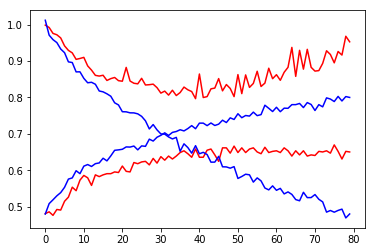

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'],'r')
plt.plot(history.history['val_acc'],'r')
plt.plot(history.history['loss'],'b')
plt.plot(history.history['acc'],'b')


SyntaxError: ignored